In [3]:
import rioxarray as rio
import xarray as xr
import glob
import os
import numpy as np
import requests
import geopandas as gpd
from pathlib import Path
from datetime import datetime
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
%matplotlib inline

all_scenes_f_precip = Path('/scratch/waves/rhone-ecostress/rasters/chirps-clipped')
all_scenes_f_et = Path('/home/serdp/rhone/rhone-ecostress/rasters/eeflux/BRC')

all_precip_paths = list(all_scenes_f_precip.glob("*"))
all_isp_et_paths = list(all_scenes_f_et.glob("*.tif"))

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4e+38, 'width': 55, 'height': 89, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unknown",GEOGCS["unknown",DATUM["Unknown_based_on_GRS80_ellipsoid",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",46.5],PARAMETER["central_meridian",3],PARAMETER["standard_parallel_1",49],PARAMETER["standard_parallel_2",44],PARAMETER["false_easting",700000],PARAMETER["false_northing",6600000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(3940.0, 0.0, 752344.6729321405,
       0.0, -5550.0, 6682060.744602234), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}
72.4 ms ± 367 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


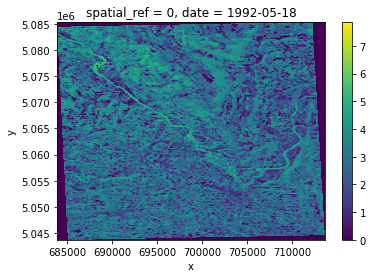

In [4]:
# for some reason the fll value is not correct. this is the correct bad value to mask by
testf = all_precip_paths[0]
x = rio.open_rasterio(testf)
badvalue = np.unique(x.where(x != x._FillValue).sel(band=1))[0]

def chirps_path_date(path):
    _, _, year, month, day, _ = path.name.split(".") 
    day = day.split("-")[0]
    return datetime(int(year), int(month), int(day))


def open_chirps(path):
    data_array = rio.open_rasterio(path) #chunks makes i lazyily executed
    data_array = data_array.sel(band=1).drop("band") # gets rid of old coordinate dimension since we need bands to have unique coord ids
    data_array["date"] = chirps_path_date(path) # makes a new coordinate
    return data_array.expand_dims({"date":1}) # makes this coordinate a dimension



### data is not tiled so not a good idea to use chunking
#https://github.com/pydata/xarray/issues/2314

import rasterio
with rasterio.open(testf) as src:
    print(src.profile)

len(all_precip_paths) * 41.7 / 10e3 # convert from in to mm

%timeit open_chirps(testf)

all_daily_precip_path = "/home/serdp/ravery/rhone-ecostress/netcdfs/all_chirps_daily_i.nc"

if Path(all_daily_precip_path).exists():
    
    all_chirps_arr = xr.open_dataarray(all_daily_precip_path)
    all_chirps_arr = all_chirps_arr.sortby("date")
else:

    daily_chirps_arrs = []

    for path in all_precip_paths:

        daily_chirps_arrs.append(open_chirps(path)) 
        
    all_chirps_arr = xr.concat(daily_chirps_arrs, dim="date")
    
    all_chirps_arr = all_chirps_arr.sortby("date")

    all_chirps_arr.to_netcdf(all_daily_precip_path)

def eeflux_path_date(path):
    year, month, day, _, _ = path.name.split("-") # Change this line accordingly based on format of eeflux dates
    return datetime(int(year), int(month), int(day))

def open_eeflux(path, da_for_match):
    data_array = rio.open_rasterio(path) #chunks makes i lazyily executed
    data_array.rio.reproject_match(da_for_match)
    data_array = data_array.sel(band=1).drop("band") # gets rid of old coordinate dimension since we need bands to have unique coord ids
    data_array["date"] = eeflux_path_date(path) # makes a new coordinate
    return data_array.expand_dims({"date":1}) # makes this coordinate a dimension

# The following lines seem to write the lists of rasters to netcdf files? Do we need to replicate for chirps?
da_for_match = rio.open_rasterio(all_isp_et_paths[0])
daily_eeflux_arrs = [open_eeflux(path, da_for_match) for path in all_isp_et_paths]
all_eeflux_arr = xr.concat(daily_eeflux_arrs, dim="date")
all_daily_eeflux_path = "/home/serdp/ravery/rhone-ecostress/netcdfs/all_eeflux_daily_i.nc"
all_eeflux_arr.to_netcdf(all_daily_eeflux_path)

all_eeflux_arr[-3,:,:].plot.imshow()

all_eeflux_arr = all_eeflux_arr.sortby("date")

In [5]:
ey = max(all_eeflux_arr['date.year'].values)

In [6]:
def years_list(all_eeflux_arr):
    ey = max(all_eeflux_arr['date.year'].values)
    sy = min(all_eeflux_arr['date.year'].values)
    start_years = range(sy, ey)
    end_years = range(sy+1, ey+1) # Change to sy+1, ey+1 for across-calendar-year (e.g. winter) calculations
    return list(zip(start_years, end_years))

def group_by_custom_doy(all_eeflux_arr, doy_start, doy_end):
    start_end_years = years_list(all_eeflux_arr)
    water_year_arrs = []
    for water_year in start_end_years:
        start_mask = ((all_eeflux_arr['date.dayofyear'].values > doy_start) & (all_eeflux_arr['date.year'].values == water_year[0]))
        end_mask = ((all_eeflux_arr['date.dayofyear'].values < doy_end) & (all_eeflux_arr['date.year'].values == water_year[0]))
        water_year_arrs.append(all_eeflux_arr[start_mask | end_mask])
    return water_year_arrs
doystart = 275 # Edit these variables to change doy length of year
doyend = 125
water_year_arrs = group_by_custom_doy(all_eeflux_arr, doystart, doyend)

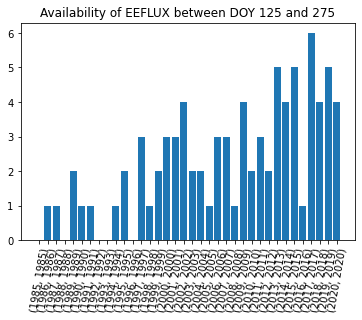

In [13]:
# Creates figure of ET availability
group_counts = list(map(lambda x: len(x['date']), water_year_arrs))
year_tuples = years_list(all_eeflux_arr)

indexes = np.arange(len(year_tuples))
plt.bar(indexes, group_counts)
degrees = 80
plt.xticks(indexes, year_tuples, rotation=degrees, ha="center")
plt.title("Availability of EEFLUX between DOY 125 and 275")
plt.savefig("eeflux_availability.png")

# Figure below shows empty years in 85, 88, 92, 93, 96; no winter precip rasters generated for these years b/c no ET data w/in winter window

In [14]:
def sum_seasonal_precip(precip_arr, eeflux_group_arr):
    return precip_arr.sel(date=slice(eeflux_group_arr.date.min(), eeflux_group_arr.date.max())).sum(dim="date")
# This is matching up precip w/ available ET window for each year

In [15]:
for index, eeflux_group in enumerate(water_year_arrs):
    if len(eeflux_group['date']) > 0:
        seasonal_precip = sum_seasonal_precip(all_chirps_arr, eeflux_group)  
        seasonal_et = eeflux_group.integrate(dim="date", datetime_unit="D")
        year_range = year_tuples[index]
        pname = f"winter_chirps_{year_range[0]}_{year_range[1]}_{doystart}_{doyend}.tif" #Edit output raster labels
        eename = f"seasonal_eeflux_integrated_{year_range[0]}_{doystart}_{doyend}.tif"
        seasonal_precip.rio.to_raster(pname)
        seasonal_et.rio.to_raster(eename)
# This chunk actually outputs the rasters

<ipython-input-15-dbd7715df0af>:4: FutureWarning: The `dim` keyword argument to `DataArray.integrate` is being replaced with `coord`, for consistency with `Dataset.integrate`. Please pass `coord` instead. `dim` will be removed in version 0.19.0.
  seasonal_et = eeflux_group.integrate(dim="date", datetime_unit="D")
<ipython-input-15-dbd7715df0af>:4: FutureWarning: The `dim` keyword argument to `DataArray.integrate` is being replaced with `coord`, for consistency with `Dataset.integrate`. Please pass `coord` instead. `dim` will be removed in version 0.19.0.
  seasonal_et = eeflux_group.integrate(dim="date", datetime_unit="D")
<ipython-input-15-dbd7715df0af>:4: FutureWarning: The `dim` keyword argument to `DataArray.integrate` is being replaced with `coord`, for consistency with `Dataset.integrate`. Please pass `coord` instead. `dim` will be removed in version 0.19.0.
  seasonal_et = eeflux_group.integrate(dim="date", datetime_unit="D")
<ipython-input-15-dbd7715df0af>:4: FutureWarning: Th

<ipython-input-15-dbd7715df0af>:4: FutureWarning: The `dim` keyword argument to `DataArray.integrate` is being replaced with `coord`, for consistency with `Dataset.integrate`. Please pass `coord` instead. `dim` will be removed in version 0.19.0.
  seasonal_et = eeflux_group.integrate(dim="date", datetime_unit="D")
<ipython-input-15-dbd7715df0af>:4: FutureWarning: The `dim` keyword argument to `DataArray.integrate` is being replaced with `coord`, for consistency with `Dataset.integrate`. Please pass `coord` instead. `dim` will be removed in version 0.19.0.
  seasonal_et = eeflux_group.integrate(dim="date", datetime_unit="D")
<ipython-input-15-dbd7715df0af>:4: FutureWarning: The `dim` keyword argument to `DataArray.integrate` is being replaced with `coord`, for consistency with `Dataset.integrate`. Please pass `coord` instead. `dim` will be removed in version 0.19.0.
  seasonal_et = eeflux_group.integrate(dim="date", datetime_unit="D")
<ipython-input-15-dbd7715df0af>:4: FutureWarning: Th

In [16]:
seasonal_precip # This just shows the array - corner cells have empty values b/c of projection mismatch @ edge of raster

<xarray.DataArray (y: 89, x: 55)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * y            (y) float64 6.679e+06 6.674e+06 ... 6.196e+06 6.191e+06
  * x            (x) float64 7.543e+05 7.583e+05 ... 9.631e+05 9.671e+05
    spatial_ref  int64 0

In [17]:
water_year_arrs[0][0].plot.imshow()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [18]:
water_year_arrs[0].integrate(dim="date", datetime_unit="D").plot.imshow()
# This chunk does the actual integration

<ipython-input-18-2edd85b98b08>:1: FutureWarning: The `dim` keyword argument to `DataArray.integrate` is being replaced with `coord`, for consistency with `Dataset.integrate`. Please pass `coord` instead. `dim` will be removed in version 0.19.0.
  water_year_arrs[0].integrate(dim="date", datetime_unit="D").plot.imshow()


ValueError: numpy.nanmin raises on a.size==0 and axis=None; So Bottleneck too.

In [19]:
all_eeflux_arr.integrate(dim="date", datetime_unit="D")

<ipython-input-19-1dea8731bb8e>:1: FutureWarning: The `dim` keyword argument to `DataArray.integrate` is being replaced with `coord`, for consistency with `Dataset.integrate`. Please pass `coord` instead. `dim` will be removed in version 0.19.0.
  all_eeflux_arr.integrate(dim="date", datetime_unit="D")


<xarray.DataArray (y: 1384, x: 992)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * y            (y) float64 5.085e+06 5.085e+06 ... 5.044e+06 5.044e+06
  * x            (x) float64 6.839e+05 6.839e+05 ... 7.136e+05 7.136e+05
    spatial_ref  int64 0

In [20]:
import pandas as pd
import numpy as np

labels = ['<=2', '3-9', '>=10']
bins = [0,2,9, np.inf]
pd.cut(all_eeflux_arr, bins, labels=labels)

ValueError: Input array must be 1 dimensional

In [21]:
all_eeflux_arr

<xarray.DataArray (date: 226, y: 1384, x: 992)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * y            (y) float64 5.085e+06 5.085e+06 ... 5.044e+06 5.044e+06
  * x            (x) float64 6.839e+05 6.839e+05 ... 7.136e+05 7.136e+05
    spatial_ref  int64 0
  * date         (date) datetime64[ns] 1985-08-19 1986-08-22 ... 2021-02-27
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

In [22]:
import pandas as pd

all_scene_ids = [str(i) for i in list(all_scenes_f.glob("L*"))]
df = pd.DataFrame({"scene_id":all_scene_ids}).reindex()
split_vals_series = df.scene_id.str.split("/")

dff = pd.DataFrame(split_vals_series.to_list(), columns=['_', '__', '___', '____', '_____', '______', 'fname'])

df['date'] = dff['fname'].str.slice(10,18)

df['pathrow'] = dff['fname'].str.slice(4,10)

df['sensor'] = dff['fname'].str.slice(0,4)

df['datetime'] = pd.to_datetime(df['date'])

df = df.set_index("datetime").sort_index()

NameError: name 'all_scenes_f' is not defined

In [23]:
marc_df = df['2014-01-01':'2019-12-31']

NameError: name 'df' is not defined

In [24]:
marc_df = marc_df[marc_df['sensor']=="LC08"]

NameError: name 'marc_df' is not defined

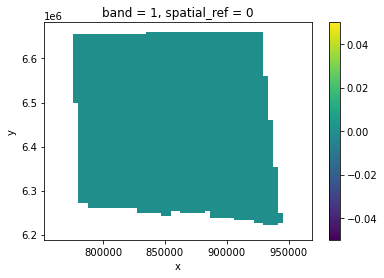

In [25]:
x.where(x != badvalue).sel(band=1).plot.imshow()

In [1]:
# Evan additions

year_tuples = years_list(all_eeflux_arr)
year_tuples


NameError: name 'years_list' is not defined

In [7]:
# Winter precip calculations
year_tuples_p = years_list(all_chirps_arr)
year_tuples_p

[(1981, 1982),
 (1982, 1983),
 (1983, 1984),
 (1984, 1985),
 (1985, 1986),
 (1986, 1987),
 (1987, 1988),
 (1988, 1989),
 (1989, 1990),
 (1990, 1991),
 (1991, 1992),
 (1992, 1993),
 (1993, 1994),
 (1994, 1995),
 (1995, 1996),
 (1996, 1997),
 (1997, 1998),
 (1998, 1999),
 (1999, 2000),
 (2000, 2001),
 (2001, 2002),
 (2002, 2003),
 (2003, 2004),
 (2004, 2005),
 (2005, 2006),
 (2006, 2007),
 (2007, 2008),
 (2008, 2009),
 (2009, 2010),
 (2010, 2011),
 (2011, 2012),
 (2012, 2013),
 (2013, 2014),
 (2014, 2015),
 (2015, 2016),
 (2016, 2017),
 (2017, 2018),
 (2018, 2019),
 (2019, 2020)]

In [9]:
def group_p_by_custom_doy(all_chirps_arr, doy_start, doy_end):
    start_end_years = years_list(all_chirps_arr)
    water_year_arrs = []
    for water_year in start_end_years:
        start_mask = ((all_chirps_arr['date.dayofyear'].values > doy_start) & (all_chirps_arr['date.year'].values == water_year[0]))
        end_mask = ((all_chirps_arr['date.dayofyear'].values < doy_end) & (all_chirps_arr['date.year'].values == water_year[0]))
        water_year_arrs.append(all_chirps_arr[start_mask | end_mask])
    return water_year_arrs
doystart = 275 # Edit these variables to change doy length of year
doyend = 125
water_year_arrs = group_p_by_custom_doy(all_chirps_arr, doystart, doyend)
water_year_arrs

[<xarray.DataArray (date: 214, y: 89, x: 55)>
 [1047530 values with dtype=float32]
 Coordinates:
   * y            (y) float64 6.679e+06 6.674e+06 ... 6.196e+06 6.191e+06
   * x            (x) float64 7.543e+05 7.583e+05 ... 9.631e+05 9.671e+05
     spatial_ref  int64 ...
   * date         (date) datetime64[ns] 1981-01-01 1981-01-02 ... 1981-12-31
 Attributes:
     STATISTICS_MAXIMUM:  0
     STATISTICS_MEAN:     0
     STATISTICS_MINIMUM:  0
     STATISTICS_STDDEV:   0
     grid_mapping:        spatial_ref,
 <xarray.DataArray (date: 214, y: 89, x: 55)>
 [1047530 values with dtype=float32]
 Coordinates:
   * y            (y) float64 6.679e+06 6.674e+06 ... 6.196e+06 6.191e+06
   * x            (x) float64 7.543e+05 7.583e+05 ... 9.631e+05 9.671e+05
     spatial_ref  int64 ...
   * date         (date) datetime64[ns] 1982-01-01 1982-01-02 ... 1982-12-31
 Attributes:
     STATISTICS_MAXIMUM:  0
     STATISTICS_MEAN:     0
     STATISTICS_MINIMUM:  0
     STATISTICS_STDDEV:   0
     grid_m

In [ ]:
def sum_seasonal_precip(precip_arr, eeflux_group_arr):
    return precip_arr.sel(date=slice(eeflux_group_arr.date.min(), eeflux_group_arr.date.max())).sum(dim="date")
# This is matching up precip w/ available ET window for each year, need to figure out what to feed in for 2nd variable

In [ ]:
for index, eeflux_group in enumerate(water_year_arrs):
    if len(eeflux_group['date']) > 0:
        seasonal_precip = sum_seasonal_precip(all_chirps_arr, eeflux_group) # Here's where above fxn is applied to rasters, need to replace eeflux_group
        year_range = year_tuples_p[index]
        pname = f"winter_chirps_{year_range[0]}_{year_range[1]}_{doystart}_{doyend}.tif" #Edit output raster labels
        seasonal_precip.rio.to_raster(pname)
# This chunk actually outputs the rasters, ET lines removed